In [1]:
import os
import glob
import random
import math
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as et
import tensorflow as tf
import numpy as np
import cv2

In [2]:
sets_txt_path = './VOC{}/ImageSets/Main/{}'
train_2012 = glob.glob(sets_txt_path.format(2012, '*_train.txt'))
val_2012 = glob.glob(sets_txt_path.format(2012, '*_val.txt'))
train_2007 = glob.glob(sets_txt_path.format(2007, '*_train.txt'))
val_2007 = glob.glob(sets_txt_path.format(2007, '*_val.txt'))
test_2007 = glob.glob(sets_txt_path.format('2007Test', '*_test.txt'))
print(len(train_2012))

20


In [3]:
train_txt_list = glob.glob('./VOC2012/ImageSets/Main/*_train.txt')
print(train_txt_list)

['./VOC2012/ImageSets/Main/dog_train.txt', './VOC2012/ImageSets/Main/horse_train.txt', './VOC2012/ImageSets/Main/chair_train.txt', './VOC2012/ImageSets/Main/cat_train.txt', './VOC2012/ImageSets/Main/train_train.txt', './VOC2012/ImageSets/Main/sheep_train.txt', './VOC2012/ImageSets/Main/bottle_train.txt', './VOC2012/ImageSets/Main/boat_train.txt', './VOC2012/ImageSets/Main/bicycle_train.txt', './VOC2012/ImageSets/Main/bus_train.txt', './VOC2012/ImageSets/Main/aeroplane_train.txt', './VOC2012/ImageSets/Main/sofa_train.txt', './VOC2012/ImageSets/Main/motorbike_train.txt', './VOC2012/ImageSets/Main/car_train.txt', './VOC2012/ImageSets/Main/tvmonitor_train.txt', './VOC2012/ImageSets/Main/person_train.txt', './VOC2012/ImageSets/Main/cow_train.txt', './VOC2012/ImageSets/Main/diningtable_train.txt', './VOC2012/ImageSets/Main/bird_train.txt', './VOC2012/ImageSets/Main/pottedplant_train.txt']


In [4]:
train_all_list, valid_all_list = list(), list()
for txt_list, all_list in zip([train_2012+train_2007+val_2007+test_2007, val_2012], [train_all_list, valid_all_list]):
    for txt in txt_list:
        path = txt[:txt.find('/', 2)+1]
        with open(txt, 'r') as f:
            all_list.extend([(path, x.split()[0]) for x in f])
print(train_all_list[:5])
random.shuffle(train_all_list)
random.shuffle(valid_all_list)
print(train_all_list[:5])
train_set, valid_set = map(set, [train_all_list, valid_all_list])
        
print(len(train_set))
print(len(valid_set))
print(next(iter(train_set)))

[('./VOC2012/', '2008_000008'), ('./VOC2012/', '2008_000015'), ('./VOC2012/', '2008_000019'), ('./VOC2012/', '2008_000023'), ('./VOC2012/', '2008_000028')]
[('./VOC2007Test/', '008041'), ('./VOC2012/', '2008_000132'), ('./VOC2007/', '002935'), ('./VOC2012/', '2010_004844'), ('./VOC2007/', '003818')]
15680
5823
('./VOC2007/', '009808')


In [5]:
voc_label = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

In [6]:
def voc_example(img_path, xml_path):
    img = open(img_path, 'rb').read()
    xml = open(xml_path, 'r')
    root = et.parse(xml).getroot()
    
    folder = root.find('folder').text
    fname = root.find('filename').text
    size = root.find('size')
    size = list(map(int, [size.find('height').text, size.find('width').text, size.find('depth').text]))
    H, W = size[:2]
    
    label, truncated, difficult, xmin, ymin, xmax, ymax = [list() for _ in range(7)]
    objects = root.findall('object')
    for obj in objects:
        label.append(voc_label.index(obj.find('name').text))
        truncated.append(int(obj.find('truncated').text))
        difficult.append(int(obj.find('difficult').text))
        bndbox = obj.find('bndbox')
        xmin.append(int(bndbox.find('xmin').text)/W)
        ymin.append(int(bndbox.find('ymin').text)/H)
        xmax.append(int(bndbox.find('xmax').text)/W)
        ymax.append(int(bndbox.find('ymax').text)/H)
                
    feature = {
        'folder': tf.train.Feature(bytes_list=tf.train.BytesList(value=[folder.encode('utf-8')])),
        'filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[fname.encode('utf-8')])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img])),
        'size': tf.train.Feature(int64_list=tf.train.Int64List(value=size)),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=label)),
        'truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult)),
        'xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [19]:
num = 2000
total = math.ceil(len(train_set)/num)
tfr_num = 0
iter_set = iter(train_set)
try:
    while True:
        with tf.io.TFRecordWriter('./tfrecord/train/voc_train_{}_of_{}.tfrecord'.format(tfr_num, total-1)) as writer:
            for i, (path, fname) in enumerate(iter_set):
                xml_path, img_path = os.path.join(path, 'Annotations', fname+'.xml'), os.path.join(path, 'JPEGImages', fname+'.jpg')
                example = voc_example(img_path, xml_path)
                writer.write(example.SerializeToString())
                if i % num == num - 1:
                    tfr_num += 1
                    break
            else:
                break
except StopIteration:
    writer.close()

In [20]:
num = 2000
total = math.ceil(len(valid_set)/num)
tfr_num = 0
iter_set = iter(valid_set)
try:
    while True:
        with tf.io.TFRecordWriter('./tfrecord/val/voc_val_{}_of_{}.tfrecord'.format(tfr_num, total-1)) as writer:
            for i, (path, fname) in enumerate(iter_set):
                xml_path, img_path = os.path.join(path, 'Annotations', fname+'.xml'), os.path.join(path, 'JPEGImages', fname+'.jpg')
                example = voc_example(img_path, xml_path)
                writer.write(example.SerializeToString())
                if i % num == num - 1:
                    tfr_num += 1
                    break
            else:
                break
except StopIteration:
    writer.close()

In [21]:
def voc_parser(example):
    feature_description = {
        'folder': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'size': tf.io.FixedLenFeature([3], tf.int64),
        'label': tf.io.VarLenFeature(tf.int64),
        'truncated': tf.io.VarLenFeature(tf.int64),
        'difficult': tf.io.VarLenFeature(tf.int64),
        'xmin': tf.io.VarLenFeature(tf.float32),
        'ymin': tf.io.VarLenFeature(tf.float32),
        'xmax': tf.io.VarLenFeature(tf.float32),
        'ymax': tf.io.VarLenFeature(tf.float32),
    }
    
    features = tf.io.parse_single_example(example, feature_description)
    update_dict = dict()
    for key, val in features.items():
        if isinstance(val, tf.SparseTensor):
            update_dict[key] = tf.sparse.to_dense(val)
    
    update_dict['image'] = tf.io.decode_jpeg(features['image'])
            
    features.update(update_dict)
    return features

In [93]:
ds = tf.data.TFRecordDataset(tf.data.TFRecordDataset.list_files('./tfrecord/train/voc_train*'))

In [29]:
features = voc_parser(next(iter(ds)))

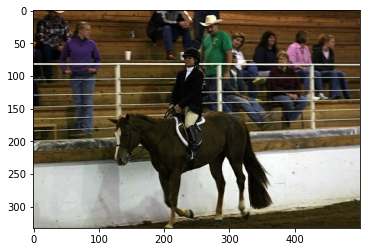

In [30]:
plt.imshow(features['image'])

In [42]:
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [60]:
def img_augmentation(img, bboxes):
    H, W, C = img.shape
    bboxes = imgaug.augmentables.bbs.BoundingBoxesOnImage(
        [BoundingBox(x1=l * W, x2=r * W, y1=t * H, y2=b * H) for l, r, t, b in bboxes],
        shape=img.shape)
    seq = imgaug.augmenters.Sequential([
        imgaug.augmenters.MultiplyHueAndSaturation(mul_hue=(0.8, 1.2), mul_saturation=(0.5, 1.5)),
        imgaug.augmenters.Fliplr(0.5),
        imgaug.augmenters.Affine(rotate=(-5, 5)),
        imgaug.augmenters.PiecewiseAffine(scale=(0.01, 0.05)),
        imgaug.augmenters.CropAndPad(percent=(-.1, .1)),
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 1.0))
    ])
    img_aug, bboxes_aug = seq(image=img, bounding_boxes=bboxes)

    return img_aug, bboxes_aug

In [61]:
img = features['image'].numpy()
xmin, ymin, xmax, ymax = features['xmin'], features['ymin'], features['xmax'], features['ymax']
bndboxes = [np.array(bndbox) for bndbox in zip(xmin, xmax, ymin, ymax)]

In [62]:
img_aug, bndbox_aug = img_augmentation(img, bndboxes)

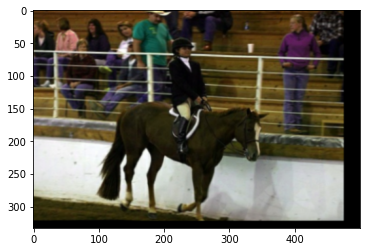

In [63]:
plt.imshow(img_aug)

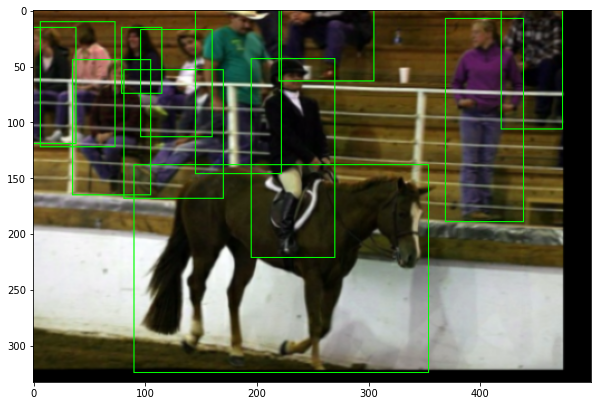

In [65]:
plt.figure(figsize=(10, 10))
plt.imshow(bndbox_aug.draw_on_image(img_aug))

In [72]:
bndbox_aug.to_xyxy_array() / 

array([[ 90.06211  , 138.07317  , 354.03726  , 324.4446   ],
       [194.61697  ,  42.640244 , 270.18634  , 221.32318  ],
       [368.53003  ,   7.1067076, 438.9234   , 188.83536  ],
       [419.25467  , -10.152439 , 474.1201   , 105.585365 ],
       [220.49689  , -15.228659 , 305.38303  ,  62.94512  ],
       [144.92754  ,  -8.121951 , 221.53209  , 146.19511  ],
       [ 80.74534  ,  52.792683 , 169.77225  , 167.51524  ],
       [ 96.27329  ,  17.259146 , 160.45547  , 112.69208  ],
       [ 78.67495  ,  15.228659 , 114.90683  ,  74.1128   ],
       [ 35.19669  ,  43.655487 , 104.55486  , 165.48476  ],
       [  6.21118  ,  10.152439 ,  73.49896  , 121.82927  ],
       [-30.020704 ,  15.228659 ,  38.302277 , 118.78353  ]],
      dtype=float32)

In [122]:
def img_augmentation(img, bboxes):
    H, W, C = img.shape
    bboxes = imgaug.augmentables.bbs.BoundingBoxesOnImage(
        [BoundingBox(x1=l * W, x2=r * W, y1=t * H, y2=b * H) for l, t, r, b in bboxes],
        shape=img.shape)
    seq = imgaug.augmenters.Sequential([
        imgaug.augmenters.MultiplyHueAndSaturation(mul_hue=(0.8, 1.2), mul_saturation=(0.5, 1.5)),
        imgaug.augmenters.Fliplr(0.5),
        imgaug.augmenters.Affine(rotate=(-5, 5)),
        imgaug.augmenters.PiecewiseAffine(scale=(0.01, 0.05)),
        imgaug.augmenters.CropAndPad(percent=(-.1, .1)),
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 1.0))
    ])
    img_aug, bboxes_aug = seq(image=img, bounding_boxes=bboxes)

    return img_aug, bboxes_aug

# def parser(x, aug=True):
#     img = x['image']
#     label = x['label']
#     xmin, ymin, xmax, ymax = x['xmin'], x['ymin'], x['xmax'], x['ymax']
def parser(img, label, xmin, ymin, xmax, ymax, aug=True):
#     img = x['image']
#     label = x['label']
#     xmin, ymin, xmax, ymax = x['xmin'], x['ymin'], x['xmax'], x['ymax']

    bndboxes = tf.transpose(tf.concat([xmin, ymin, xmax, ymax], axis=0))

    if aug:
        img, bndboxes = img_augmentation(img, bndboxes)
        H, W = img.shape[:2]
        bndboxes = bndboxes.to_xyxy_array() / np.array([W, H, W, H])

    return img, label, bndboxes

In [123]:
ds_voc = ds.map(voc_parser)

In [124]:
ds_aug = ds_voc.map(lambda x: tf.py_function(parser, [x['image'], x['label'], x['xmin'], x['ymin'], x['xmax'], x['ymax']], [tf.uint8, tf.int64, tf.float32]))

In [125]:
ds_aug_take = ds_aug.take(1)

In [126]:
for sample in ds_aug_take:
    print(sample)

InvalidArgumentError: TypeError: Cannot iterate over a scalar tensor.
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/script_ops.py", line 234, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/script_ops.py", line 123, in __call__
    ret = self._func(*args)

  File "<ipython-input-122-5cfd518f0381>", line 30, in parser
    img, bndboxes = img_augmentation(img, bndboxes)

  File "<ipython-input-122-5cfd518f0381>", line 4, in img_augmentation
    [BoundingBox(x1=l * W, x2=r * W, y1=t * H, y2=b * H) for l, t, r, b in bboxes],

  File "<ipython-input-122-5cfd518f0381>", line 4, in <listcomp>
    [BoundingBox(x1=l * W, x2=r * W, y1=t * H, y2=b * H) for l, t, r, b in bboxes],

  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py", line 545, in __iter__
    raise TypeError("Cannot iterate over a scalar tensor.")

TypeError: Cannot iterate over a scalar tensor.


	 [[{{node EagerPyFunc}}]]

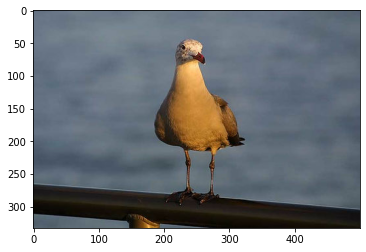

In [114]:
plt.imshow(sample[0])